# Working with `Community`s

the `Community` object is geosnap's central data structure. A `Community` is a dataset that stores information about a collection of neighborhoods over several time periods, including each neighborhood's physical, socioeconomic, and demographic attributes and its demarcated boundaries. Under the hood, each `Community` is simply a long-form geopandas geodataframe with some associated metadata. 

If you're working with built-in data, you instantiate a `Community` by choosing the constructor for your dataset and passing either a boundary (geodataframe) or a selection filter that defines the study area. The selection filter can be either a `GeoDataFrame` boundary or a set of [FIPS](https://www.policymap.com/2012/08/tips-on-fips-a-quick-guide-to-geographic-place-codes-part-iii/) codes. Boundary queries are often more convenient but they are  more expensive to compute and will take longer to construct.

When constructing `Community`s from fips codes, the constructor has arguments for state, county, msa, or list of any arbitrary fips codes. If more than one of these arguments is passed, geosnap will use the union. This means that each level of the hierarchy is available for convenience but you are free to mix and match msas, states, counties, and even single tracts to create your study region of choice

If you're working with your own data, you instantiate a `Community` by passing a list of geodataframes (or a single long-form).

In [1]:
from geosnap.data import Community

/Users/knaaptime/anaconda3/envs/geosnap/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/Users/knaaptime/anaconda3/envs/geosnap/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


## Create a `Community` from built-in census data

The quickest and easiest method for getting started is to instantiate a Community using the built-in census data. To do so, you use the `Community.from_census` constructor:

In [2]:
# this will create a new community using data from Washington DC (which is fips code 11)
dc = Community.from_census(state_fips='11')

Note that when using `Community.from_census`, the resulting community has *unharmonized* tract boundaries, meaning that the tracts are different for each decade

To access the underlying data from a `Community`, simply call its `gdf` attribute which returns a geodataframe

In [8]:
dc.gdf.head()

,geoid,geometry,median_contract_rent,median_home_value,median_household_income,median_income_asianhh,median_income_blackhh,median_income_hispanichh,median_income_whitehh,n_age_5_older,...,p_unemployment_rate,p_vacant_housing_units,p_veterans,p_vietnamese_persons,p_white_over_60,p_white_over_65,p_white_under_15,p_widowed_divorced,per_capita_income,year
53214,11001001600,POLYGON ((-77.02680206298828 38.98410034179688...,477.0,285100.0,75252.0,NaN,NaN,NaN,NaN,4.742191e+70,...,0.0,2.58,1.028308e+08,0.00,3.159920e+25,4.999423e+17,1.378187e+24,0.0,32166.0,1990
53215,11001001500,POLYGON ((-77.05280303955078 38.98649978637695...,1001.0,366000.0,79681.0,NaN,NaN,NaN,NaN,1.025723e+72,...,0.0,3.38,7.095389e+07,0.23,6.529311e+30,1.483617e+23,6.816417e+33,0.0,36452.0,1990
53216,11001001701,POLYGON ((-77.02660369873047 38.97769927978516...,429.0,135600.0,34420.0,NaN,NaN,NaN,NaN,6.918716e+64,...,0.0,3.89,8.990532e+05,0.10,1.184601e+14,1.285720e+10,8.476736e+15,0.0,17782.0,1990
53217,11001001801,POLYGON ((-77.02660369873047 38.97769927978516...,1001.0,0.0,77197.0,NaN,NaN,NaN,NaN,3.084115e+31,...,0.0,10.00,5.229000e+01,0.00,1.450982e+11,1.437909e+08,1.321830e+14,0.0,14679.0,1990
53218,11001001702,POLYGON ((-77.00859832763672 38.97000122070312...,514.0,129300.0,42661.0,NaN,NaN,NaN,NaN,4.210494e+62,...,0.0,3.96,7.219278e+04,0.04,4.438992e+13,2.147213e+10,2.352939e+17,0.0,20468.0,1990


In [12]:
# create a little helper function for plotting a time-series

import matplotlib.pyplot as plt

def plot(community, column):
    fig, axs = plt.subplots(1,3, figsize=(15,5))
    axs=axs.flatten()

    community.gdf[community.gdf.year==1990].dropna(subset=[column]).plot(column=column, scheme='quantiles', cmap='Blues', k=6, ax=axs[0])
    axs[0].axis('off')
    axs[0].set_title('1990')

    community.gdf[community.gdf.year==2000].dropna(subset=[column]).plot(column=column, scheme='quantiles', cmap='Blues', k=6, ax=axs[1])
    axs[1].axis('off')
    axs[1].set_title('2000')

    community.gdf[community.gdf.year==2010].dropna(subset=[column]).plot(column=column, scheme='quantiles', cmap='Blues', k=6, ax=axs[2])
    axs[2].axis('off')
    axs[2].set_title('2010')

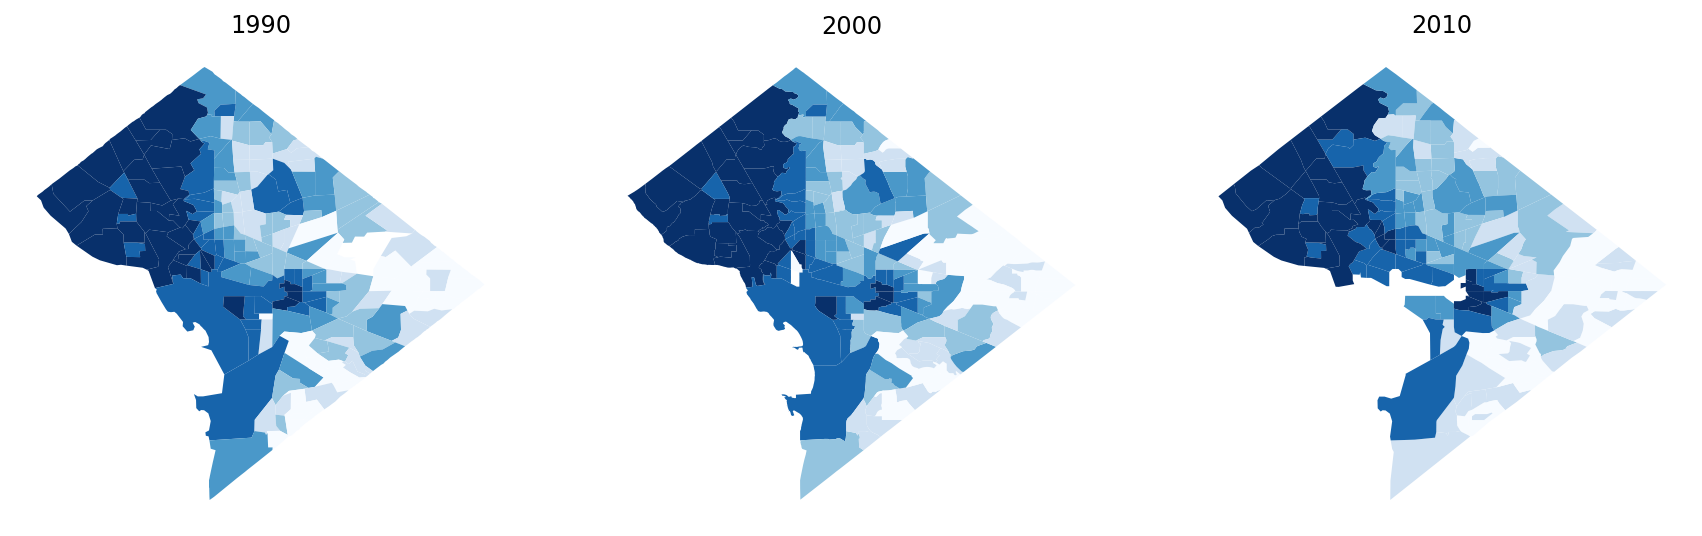

In [13]:
plot(dc, 'p_nonhisp_white_persons')

## Create a `Community` from a longitudinal database

To instantiate a `Community` from a longitudinal database, you must first register the database with geosnap using either `store_ltdb` or `store_ncdb`. Once the data are available in the data_store, you can call `Community.from_ltdb` and `Community.from_ncdb`

### LTDB using fips codes

I don't know the Riverside MSA fips code by heart, so I'll slice through the `msas` dataframe in the data store to find it

In [3]:
from geosnap.data import data_store as store

In [4]:
store.msas()[store.msas().name.str.startswith('Riverside')]

,geoid,name,type,geometry
725,40140,"Riverside-San Bernardino-Ontario, CA",Metro Area,"POLYGON ((-117.673749 33.870831, -117.673941 3..."


In [5]:
riverside = Community.from_ltdb(msa_fips='40140')

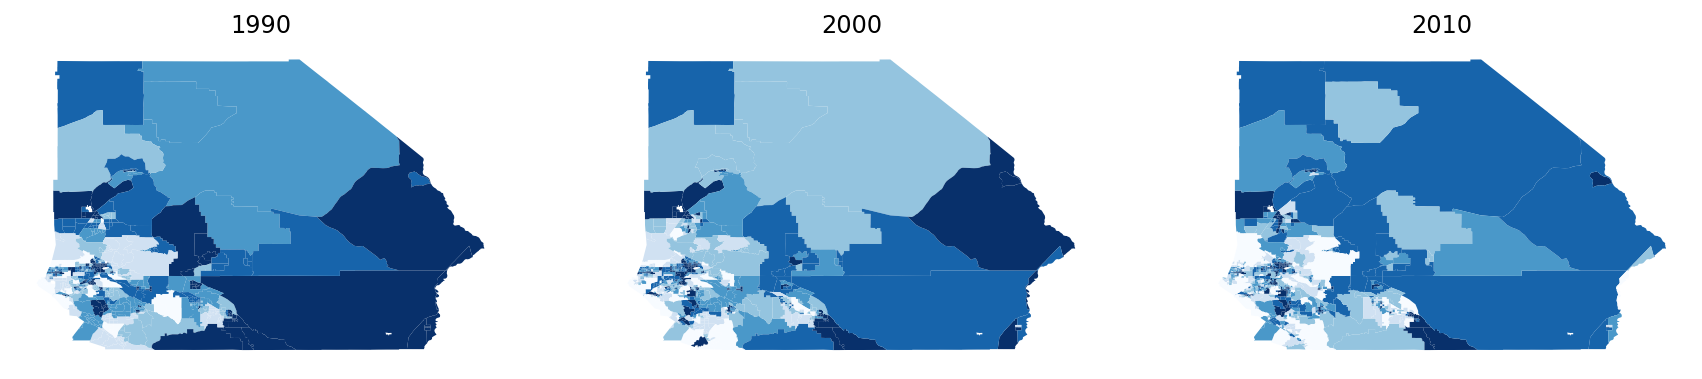

In [17]:
plot(riverside, 'p_poverty_rate')

Instead of passing a fips code, I could use the `boundary` argument to pass the riverside MSA as a geodataframe. This is more computationally expensive because it requires geometric operations, but is more flexible because it allows you to create communities that don't nest into fips hierarchies (like zip codes, census designated places, or non-US data)

### NCDB Using a boundary

In [6]:
# grab the boundary for Sacramento from libpysal's built-in examples

import geopandas as gpd
import libpysal
sac = gpd.read_file(libpysal.examples.get_path('sacramentot2.shp'))

In [7]:
sacramento = Community.from_ncdb(boundary=sac)

/Users/knaaptime/projects/geosnap/geosnap/data/data.py:1000: UserWarning:

Unable to determine whether boundary CRS is WGS84 if this produces unexpected results, try reprojecting



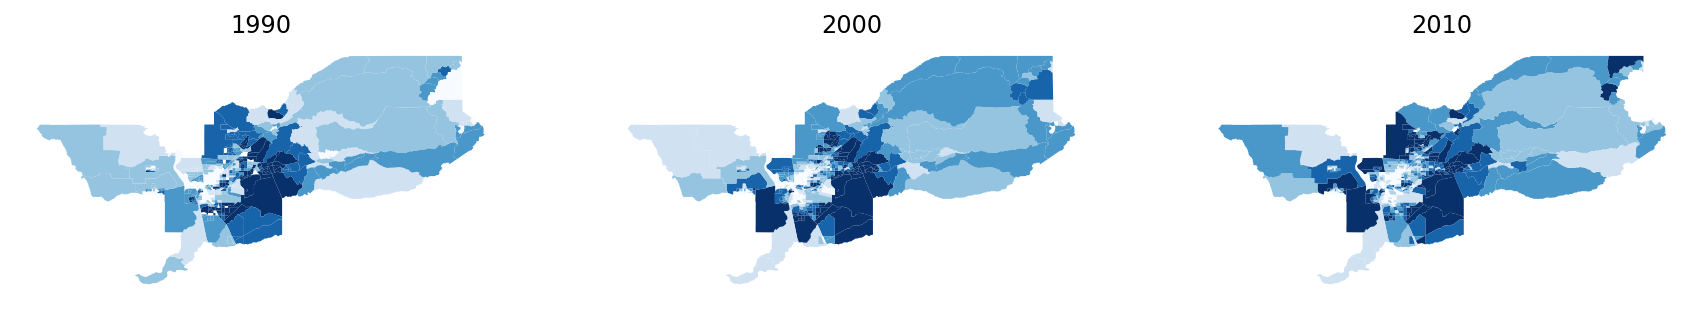

In [16]:
plot(sacramento, 'median_household_income')

## Create a `Community` from a list of geodataframes

If you are working outside the US, or if you have data that aren't included in geosnap (like census blocks or zip codes) then you can still create a community using the `Community.from_geodataframes` constructor, which allows you to pass a list of geodataframes that will be concatenated into the single long-form gdf structure that geosnap's analytics expect.

This constructor is typically used in cases where a researcher has several shapefiles for a study area, each of which pertainin to a different time period. In such a case, the user would read each shapefile into a geodataframe and ensure that each has a "time" column that will differentiate each time period from one another in the long-form structure (e.g. if each shapefile is a different decade, then the 1990 shapefile should have a column called "year" in which every observation has a value of 1990). Then, these geodataframes simply need to be passed in a list to the `from_geodataframes` constructor

Here, I'll use `cenpy` to grap population data from two different ACS vintages and combine them into a single community

In [18]:
from cenpy.products import ACS

In [26]:
chi13 = ACS(2013).from_place('chicago', variables='B00001_001E')

Matched: chicago to Chicago city within layer Incorporated Places


In [38]:
chi13['year'] = 2013

In [28]:
chi17 = ACS(2017).from_place('chicago', variables='B00001_001E')

Matched: chicago to Chicago city within layer Incorporated Places


In [37]:
chi17['year'] = 2017

In [39]:
chicago = Community.from_geodataframes([chi13, chi17])

Text(0.5, 1, '2017')

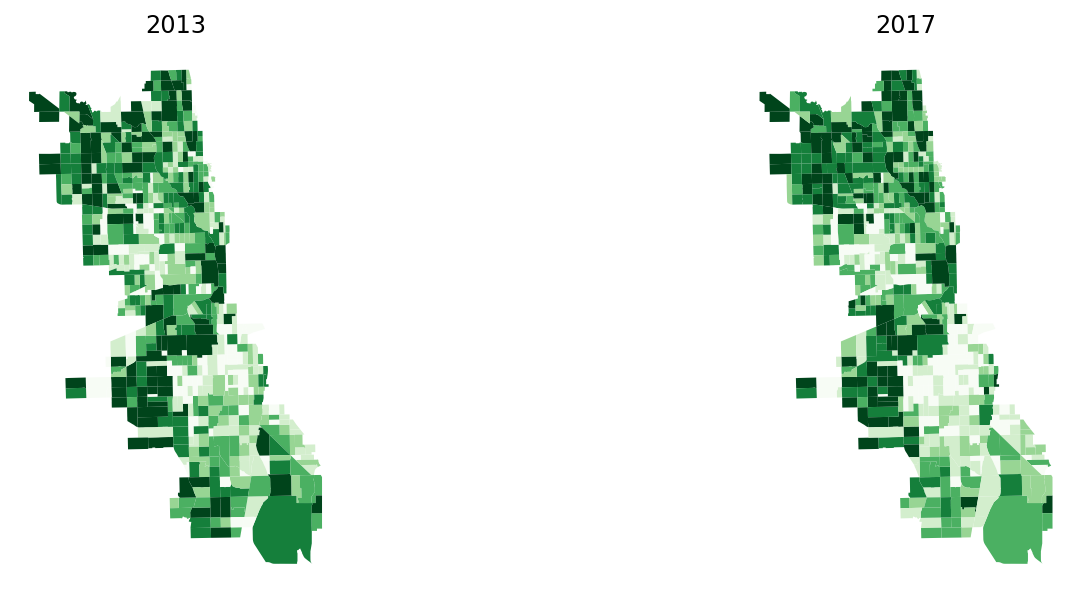

In [42]:
fig, axs = plt.subplots(1,2, figsize=(12,5))

chicago.gdf[chicago.gdf.year==2013].dropna(subset=['B00001_001E']).plot(column='B00001_001E', cmap='Greens', scheme='quantiles', k=6, ax=axs[0])
axs[0].axis('off')
axs[0].set_title('2013')
chicago.gdf[chicago.gdf.year==2017].dropna(subset=['B00001_001E']).plot(column='B00001_001E', cmap='Greens', scheme='quantiles', k=6, ax=axs[1])
axs[1].axis('off')
axs[1].set_title('2017')